In [1]:
import pandas as pd
import xarray as xr

dir_list_df = pd.read_csv('/user/ab5405/summeraliaclimate/code/dir_list.csv', index_col=0)
dir_list = dir_list_df['dir_path'].to_dict()


In [2]:
from funcs_support import get_filepaths

df_paths = get_filepaths(source_dir='proc', dir_list=dir_list)
df_paths.head()

,varname,freq,model,exp,run,gwl,proj_method,proj_base,dwnscl_method,dwnscl_target,suffix,filetype,path
0,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r22i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...
1,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r1i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...
2,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r2i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...
3,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r11i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...
4,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r25i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...


In [3]:
df = df_paths.query("varname == 'tasdmgfparams' and gwl == 'ALLGWLs'").copy()
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [4]:
import numpy as np
import pandas as pd

In [6]:
dmgf = xr.DataArray([0.69,0.59,0.64,0.36,0.27,0,0.12,0.23,0.33,0.94],dims=['bin'],coords=[np.arange(1,11)])
bins_dng = np.append(np.append(-np.inf,(np.arange(10,91,10)+459.67)*5/9),np.inf)
bin_name_dng = '_dng'

# This was total county income, Table 3. Wanted Table 2 instead
#dmgf_dnh = xr.DataArray([6.55,4.28,-1.73,-5.74,-10.61,-5.47,-3.12,-2.47,-1.07,-1.00,0,-2.77,-7.46,-6.92,-14.78,-16.71,-20.56],
#                          dims=['bin'],coords=[np.arange(1,18)])

# This is from table 2: "The effect of daily temperature on log total annual income per capita"
dmgf_dnh = xr.DataArray([0.000234,0.000126,-0.000144,-0.000269,-0.000322,-0.000195,-0.000119,-0.000074,-0.000003,-0.000036,
                         0,-0.000111,-0.000311,-0.000294,-0.000585,-0.000646,-0.000757],
                           dims=['bin'],coords=[np.arange(1,18)])
bins_dnh = np.append(np.append(-np.inf,np.arange(-15,31,3)+273.15),np.inf)
bin_name_dnh = '_dnh'

In [69]:
bin_edges_dng = np.array([
    -np.inf,
    *(((np.arange(10, 91, 10) + 459.67) * 5/9)),  # 10°F to 90°F inclusive
    np.inf
])

bin_edges_dnh = np.append(np.append(-np.inf, np.arange(-15, 31, 3) + 273.15), np.inf)


impact_dng_list = []
impact_dnh_list = []
model_labels = []
run_labels = []

dmgf_dng_coarse = dmgf.coarsen(bin=2, boundary='pad').sum()
dmgf_dnh_coarse = dmgf_dnh.coarsen(bin=2, boundary='pad').sum()

for i, row in df.iterrows():
    ds = xr.open_zarr(row['path'])

    gwl_2 = ds['bins_behrer'].sel(gwl=2.0, method='nearest')
    gwl_06 = ds['bins_behrer'].sel(gwl=0.61, method='nearest')
    diff = gwl_2 - gwl_06

    rebinned = diff.coarsen(bin_f=2, boundary = 'pad').sum()
    rebinned = rebinned.rename({'bin_f': 'bin_rebinned'})

    impact_dng = (rebinned * dmgf_dng_coarse).sum(dim='bin_rebinned')
    impact_dnh = (rebinned * dmgf_dnh_coarse).sum(dim='bin_rebinned')

    impact_dng_list.append(impact_dng)
    impact_dnh_list.append(impact_dnh)
    model_labels.append(row['model'])
    run_labels.append(row['run'])


In [71]:
ds = xr.open_zarr(df.iloc[0]['path'])
print(np.round(ds['bin_f'].values, 2))

[253.98 256.76 259.54 262.32 265.09 267.87 270.65 273.43 276.21 278.98
 281.76 284.54 287.32 290.09 292.87 295.65 298.43 301.21 303.98 306.76
 309.54 312.32]


In [72]:
def rebin_to_damage_bins(diff, bin_f_vals, bin_edges, dmgf):
    rebinned = []
    for i in range(len(bin_edges) - 1):
        mask = (bin_f_vals >= bin_edges[i]) & (bin_f_vals < bin_edges[i+1])
        rebinned.append(diff.sel(bin_f=mask).sum(dim='bin_f'))

    rebinned = xr.concat(rebinned, dim='bin')
    rebinned.coords['bin'] = dmgf['bin']
    return rebinned

In [73]:
ds = xr.open_zarr(df.iloc[0]['path'])
bin_f_vals = ds['bin_f'].values

gwl2 = ds['bins_behrer'].sel(gwl=2.0, method='nearest')
gwl06 = ds['bins_behrer'].sel(gwl=0.61, method='nearest')
diff = gwl2 - gwl06

rebinned_dng = rebin_to_damage_bins(diff, bin_f_vals, bin_edges_dng, dmgf)
print(rebinned_dng.shape)
print(rebinned_dng.coords['bin'].values)

(10, 120, 268)
[ 1  2  3  4  5  6  7  8  9 10]


In [75]:
lat_idx = 35
lon_idx = 150

print("Days per bin:", np.round(rebinned_dng[:, lat_idx, lon_idx].values, 2))
print("Dmgf:", dmgf.values)

impact = (rebinned_dng[:, lat_idx, lon_idx] * dmgf).compute().sum().item()
print(f"Expected impact at ({lat_idx},{lon_idx}):", impact)

Days per bin: [-15.4    2.8   -3.1   -4.2  -14.6    0.45   9.9   23.5    0.65   0.  ]
Dmgf: [0.69 0.59 0.64 0.36 0.27 0.   0.12 0.23 0.33 0.94]
Expected impact at (100,150): -9.604500000000002


In [83]:
lat_phx = 33.45
lon_phx = -112.07

def check_impact_phoenix(rebinned, dmgf, lat_phx=33.45, lon_phx=-112.07):
    lat_idx = abs(rebinned.lat - lat_phx).argmin().item()
    lon_idx = abs(rebinned.lon - lon_phx).argmin().item()

    days_in_bins = rebinned.isel(lat=lat_idx, lon=lon_idx).values
    dmgf_vals = dmgf.values

    if len(days_in_bins) != len(dmgf_vals):
        raise ValueError(f"Mismatch: {len(days_in_bins)} days vs {len(dmgf_vals)} dmgf bins")

    impact = float((days_in_bins * dmgf_vals).sum())
    print("Phoenix days in each bin:", np.round(days_in_bins, 2))
    print("Damage function values:   ", np.round(dmgf_vals, 3))
    print("Phoenix estimated impact: ", round(impact, 2))
    return impact


impact_phx_dng = check_impact_phoenix(rebinned_dng, dmgf)



Phoenix days in each bin: [  0.     0.    -0.05  -0.7  -15.9   -9.45   6.6   -2.7   -6.1   28.3 ]
Damage function values:    [0.69 0.59 0.64 0.36 0.27 0.   0.12 0.23 0.33 0.94]
Phoenix estimated impact:  20.18


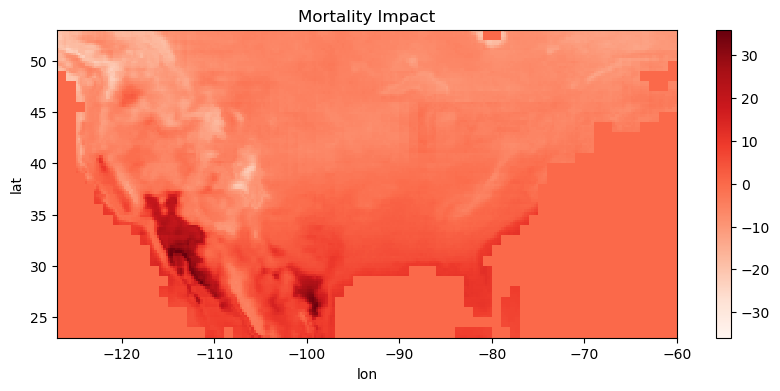

In [76]:
impact_map = (rebinned_dng * dmgf).sum(dim='bin')
impact_map.plot(cmap='Reds', figsize=(10, 4))
plt.title("Mortality Impact")
plt.show()


In [68]:
for i, row in df.iterrows():
    ds = xr.open_zarr(row['path'])

    # Convert bin_f to °F (if not already)
    bin_f_K = ds['bin_f'].values
    bin_f_F = (bin_f_K - 273.15) * 9/5 + 32
    ds = ds.assign_coords(bin_f=bin_f_F)

    # Select warming levels
    gwl_2 = ds['bins_behrer'].sel(gwl=2.0, method='nearest')
    gwl_06 = ds['bins_behrer'].sel(gwl=0.61, method='nearest')
    diff = gwl_2 - gwl_06  # shape: (bin_f, lat, lon)

    # Manual binning using np.digitize
    bin_indices_dng = np.digitize(ds['bin_f'].values, bin_edges_dng) - 1  # adjust to 0-based
    rebinned_dng = xr.DataArray(
        np.zeros((len(bin_edges_dng)-1, diff.shape[1], diff.shape[2])),
        dims=('bin', 'lat', 'lon'),
        coords={'bin': np.arange(len(bin_edges_dng)-1), 'lat': ds.lat, 'lon': ds.lon}
    )

    for b in range(len(bin_edges_dng)-1):
        mask = bin_indices_dng == b
        rebinned_dng[b] = diff[mask, :, :].sum(dim='bin_f')

    # Same logic for dnh if needed, using bin_edges_dnh

    # Multiply
    dmgf_dng_array = dmgf.values  # match shape to rebinned_dng
    impact_dng = (rebinned_dng * dmgf_dng_array[:, None, None]).sum(dim='bin')
    impact_dng_list.append(impact_dng)

NameError: name 'bin_edges_dng' is not defined